In [1]:
import pandas as pd
import json
import os
from tqdm import tqdm
from ftlangdetect import detect

def parse_gemini_response(response_text):
    json_str = response_text.split('```json\n')[1].split('\n```')[0]
    info = json.loads(json_str)
    return info

# Question generation prompt
with open("prompts/impact_extraction_v3.txt", "r") as f:
    impact_prompt_template = f.read()

# Save all claims and search results
save_folder = "data"

df = pd.read_csv('data/fnd_politifact_claims_final.csv')
df.columns, len(df)

(Index(['claim', 'claim_factcheck_url', 'claim_author', 'claim_source',
        'claim_date', 'fact_check_date', 'justification',
        'fact_checking_sources', 'issue', 'label'],
       dtype='object'),
 2684)

In [79]:
from utils.gemini_interface_parallel import batch_process

secrets_file = "secrets/gemini_keys_new.json"
model_name = "gemini-2.0-flash-exp"
# model_name = "gemini-1.5-flash-latest"
temperature = 0.25
top_p = 0.95

# Generate impact score for all claims
claim_iscores_filename = f"{save_folder}/claim_impact_scores.json"
try:    
    with open(claim_iscores_filename, "r", encoding="utf-8") as fp:
        claim_iscores = json.load(fp)
except FileNotFoundError:
    claim_iscores = {}

print(f"{len(claim_iscores)} claims already processed")

2557 claims already processed


In [75]:
prompts = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    # if index == 2000:
    #     break

    claim = row["claim"]
    claim_filtered = claim.replace("\n", " ")

    if detect(text=claim_filtered, low_memory=False)["lang"] != "en":
        print(f"Skipping claim |{claim}| because it is not in English")
        continue
    
    if claim in claim_iscores:
        continue
    
    # claim_author = row["claim_author"].strip() if "claim_author" in row and pd.notna(row["claim_author"]) and row["claim_author"] is not None else "UNKNOWN"
    # claim_source = row["claim_source"].strip() if "claim_source" in row and pd.notna(row["claim_source"]) and row["claim_source"] is not None else "UNKNOWN"
    # claim_date = row["claim_date"].strip() if "claim_date" in row and pd.notna(row["claim_date"]) and row["claim_date"] is not None else "UNKNOWN"
    
    # Generate questions using Gemini API
    prompt = impact_prompt_template.replace("[Insert Claim Here]", claim)
    prompts.append(
                    ("chat", 
                     prompt,
                     claim
                    )
                )
    
print("Total prompts:", len(prompts))
    
responses = batch_process(prompts, secrets_file, model_name, temperature, top_p)

failed_urls = []
for response in responses:
    url = response[1]
    if response[0] is None:
        failed_urls.append(url)
        continue

    try:    
        claim_iscores[claim] = parse_gemini_response(response[0].text)
    except:
        print("Failed to parse response for claim:", claim)
        print(response)
        continue


print("Total failed claims:", len(failed_row_ids))

# Save claim_iscores after each claim
with open(claim_iscores_filename, "w", encoding="utf-8") as fp:
    json.dump(claim_iscores, fp, indent=4)

100%|██████████| 2684/2684 [00:00<00:00, 26491.69it/s]

Skipping claim |El senador Rick Scott no apoya las excepciones al aborto.| because it is not in English
Skipping claim |Foto muestra a un delfín rosado en la costa de Carolina del Norte.| because it is not in English
Skipping claim |Video muestra vacas muriendo “en extrañas circunstancias” para reemplazarlas por “carne sintética”.| because it is not in English
Skipping claim |En China se están fabricando huevos artificiales para el consumo humano.| because it is not in English
Skipping claim |Una ballena se traga a dos mujeres en California.| because it is not in English
Skipping claim |Este es “vídeo de una inmigrante haitiana que asesinó y se comió al gato de sus vecinos” en Springfield, Ohio.| because it is not in English
Skipping claim |“El gobierno de Estados Unidos estará otorgando 30,000 visas mensuales" para personas de Colombia, Guatemala, Honduras y El Salvador "para poder venir a vivir a los Estados Unidos por dos años con permiso de trabajo".| because it is not in English
S

Total processes: 7
Total prompts: 641
Configured process time:  6.0
Process Process-48 using key: ****Mxzm4
Process Process-48 - received task-id: "Google proves that no one ever went to the moon.”
Configured process time:  6.0
Process Process-44 using key: ****or1fk
Configured process time:  6.0
Process Process-47 using key: ****Luo_s
Process Process-44 - received task-id: "Last time Democrats removed a Republican from the ballot” was Abraham Lincoln in 1860.
Process Process-47 - received task-id: If Texas says, “‘We don’t want to be part of America anymore’ … that’s their decision to make.”
Configured process time:  6.0
Process Process-43 using key: ****ncYtw
Process Process-43 - received task-id: “The left is determined to erase Mount Rushmore from our history books.”
Configured process time:  6.0
Process Process-46 using key: ****CDS14
Process Process-46 - received task-id: Glenn Youngkin is “the first sitting Governor in the modern era to have their party have less legislative sea

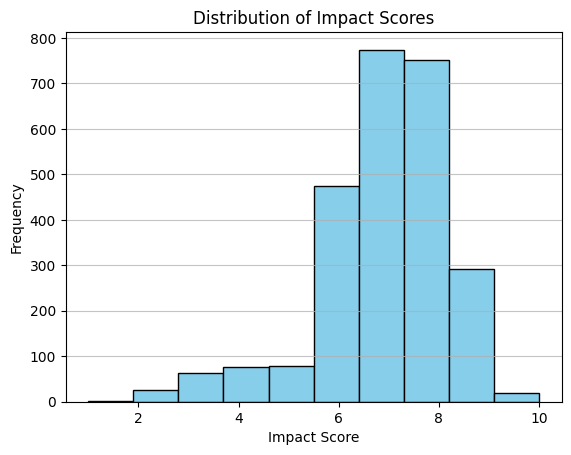

In [76]:
# Build a graph of the histogram of the impact scores
import matplotlib.pyplot as plt
import json
import numpy as np

save_folder = "data"
claim_iscores_filename = f"{save_folder}/claim_impact_scores.json"
with open(claim_iscores_filename) as fp:
    claim_iscores = json.load(fp)

plt.hist([obj["Impact Score"] for obj in claim_iscores.values()], bins=10, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of Impact Scores')
plt.xlabel('Impact Score')
plt.ylabel('Frequency')
plt.show()

# Print average impact score
print(np.mean([obj["Impact Score"] for obj in claim_iscores.values()]))

### Get final analytics

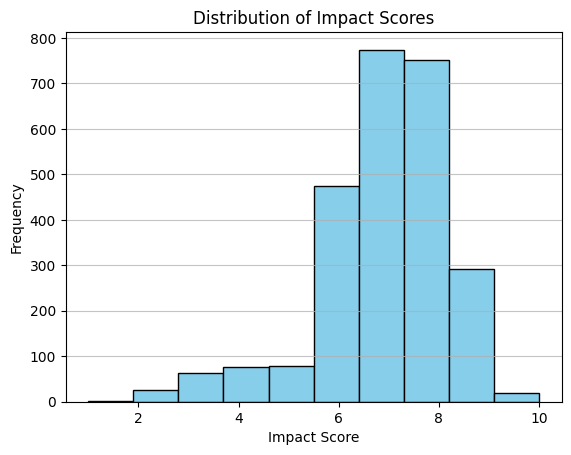

MEAN score:  7.0555338287055145


In [8]:
# Build a graph of the histogram of the impact scores
import matplotlib.pyplot as plt
import json
import numpy as np

with open("data/dataset_politifact.json", "r", encoding="utf-8") as f:
    data = json.load(f)

scores = [obj["impact_analysis"]["Impact Score"] for obj in data]
plt.hist(scores, bins=10, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of Impact Scores')
plt.xlabel('Impact Score')
plt.ylabel('Frequency')
plt.show()

# Print average impact score
print("MEAN score: ", np.mean(scores))

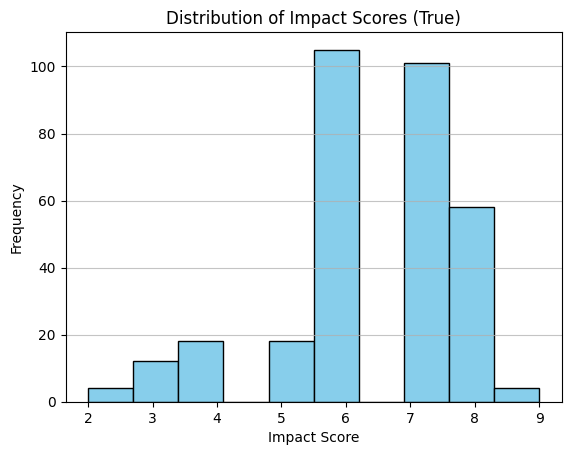

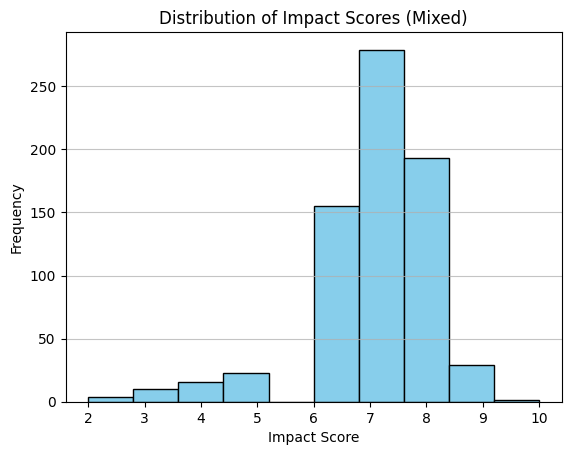

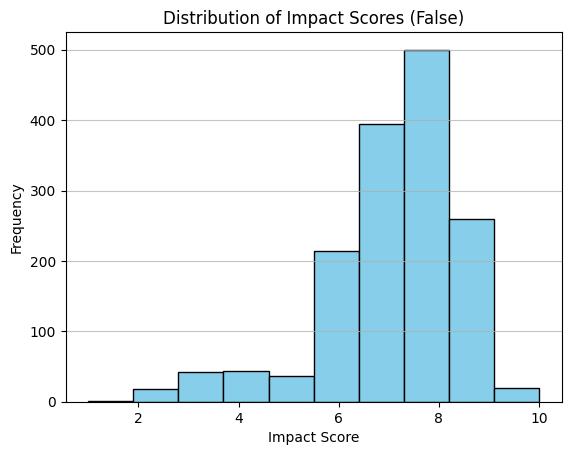

In [9]:
# I need to get the mix, max and mean score for each label
from collections import defaultdict

label_map = {
    "True": "True",
    "Mostly True": "True",
    "Half True": "Mixed",       
    "Mostly False": "Mixed",
    "False": "False",
    "Pants on Fire": "False" 
}

# label_map = {
#     "True": "True",
#     "Mostly True": "True",
#     "Mostly False": "False",
#     "False": "False",
# }

# Plot a histogram of the impact scores per label

scores_by_label = defaultdict(list)
for obj in data:
    label = label_map[obj["label"]]
    scores_by_label[label].append(obj["impact_analysis"]["Impact Score"])

for label, scores in scores_by_label.items():
    plt.hist(scores, bins=10, color='skyblue', edgecolor='black')
    plt.grid(axis='y', alpha=0.75)
    plt.title(f'Distribution of Impact Scores ({label})')
    plt.xlabel('Impact Score')
    plt.ylabel('Frequency')
    plt.show()